In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import SimpleRNN,Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical, plot_model
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
## Loading the dataset

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769


In [ ]:
def train_data_prep(X,y,sub_sample,average,noise, trim=500):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:trim]
    #print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,500) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    #print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    #print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    #print('Shape of X after subsampling and concatenating:',total_X.shape)
    #print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X, trim=500):
    
    total_X = None
    
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:trim]
    #print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,500) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    
    
    total_X = X_max
    #print('Shape of X after maxpooling:',total_X.shape)
    
    return total_X


def split_train_valid(X, y, num_samples, num_valid):
    ind_valid = np.random.choice(num_samples, num_valid, replace=False)
    ind_train = np.array(list(set(range(num_samples)).difference(set(ind_valid))))
    return X[ind_train], y[ind_train], X[ind_valid], y[ind_valid]

def split_by_person(a, person_file, index, num_samples):
    person_indices = np.asarray(person_file.flatten() == index).nonzero()
    other_indices = np.array(list(set(range(num_samples)).difference(set(person_indices[0]))))
    return a[person_indices[0]], a[other_indices]

def plot_data(x, y, num_samples=250):
    ch_data = x[:,8,:]

    class_0_ind = np.where(y == 0)
    ch_data_class_0 = ch_data[class_0_ind]
    avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)
    
    
    class_1_ind = np.where(y == 1)
    ch_data_class_1 = ch_data[class_1_ind]
    avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)
    
    class_2_ind = np.where(y == 2)
    ch_data_class_2 = ch_data[class_2_ind]
    avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)
    
    class_3_ind = np.where(y == 3)
    ch_data_class_3 = ch_data[class_3_ind]
    avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)
    
    
    plt.plot(np.arange(num_samples),avg_ch_data_class_0)
    plt.plot(np.arange(num_samples),avg_ch_data_class_1)
    plt.plot(np.arange(num_samples),avg_ch_data_class_2)
    plt.plot(np.arange(num_samples),avg_ch_data_class_3)
    
    plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])
    plt.show()
    

In [4]:
## Preprocessing the dataset

#split data for subject 1
x_person_1_valid, x_person_1_train = split_by_person(X_train_valid, person_train_valid, 0, 2115)
y_person_1_valid, y_person_1_train = split_by_person(y_train_valid, person_train_valid, 0, 2115)

x_person_1_test, z = split_by_person(X_test, person_test, 0, 443)
y_person_1_test, j = split_by_person(y_test, person_test, 0, 443)

print('Person 1 Data Before Prep')
plot_data(x_person_1_valid, y_person_1_valid, 1000)

#prep data for subject 1
x_person_1_train,y_person_1_train = train_data_prep(x_person_1_train,y_person_1_train,2,2,True)

print('Person 1 Training Data After Prep')
plot_data(x_person_1_train, y_person_1_train)

x_person_1_valid = test_data_prep(x_person_1_valid)
x_person_1_test = test_data_prep(x_person_1_test)

print('All Subject Data Before Prep')
plot_data(X_train_valid, y_train_valid, 1000)

#split data for all subjects
x_train, y_train, x_valid, y_valid = split_train_valid(X_train_valid, y_train_valid, 2115, 443)

#prep data for all subjects
x_train,y_train = train_data_prep(x_train,y_train,2,2,True)
x_valid =  test_data_prep(x_valid)
X_test_prep = test_data_prep(X_test)

print('All Subject Training Data After Prep')
plot_data(x_train, y_train)

print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)

y_person_1_train = to_categorical(y_person_1_train, 4)
y_person_1_valid = to_categorical(y_person_1_valid, 4)
y_person_1_test = to_categorical(y_person_1_test, 4)

print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)

x_person_1_train = x_person_1_train.reshape(x_person_1_train.shape[0], x_person_1_train.shape[1], x_person_1_train.shape[2], 1)
x_person_1_valid = x_person_1_valid.reshape(x_person_1_valid.shape[0], x_person_1_valid.shape[1], x_person_1_valid.shape[2], 1)
x_person_1_test = x_person_1_test.reshape(x_person_1_test.shape[0], x_person_1_test.shape[1], x_person_1_test.shape[2], 1)

print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)

x_person_1_train = np.swapaxes(x_person_1_train, 1,3)
x_person_1_train = np.swapaxes(x_person_1_train, 1,2)
x_person_1_valid = np.swapaxes(x_person_1_valid, 1,3)
x_person_1_valid = np.swapaxes(x_person_1_valid, 1,2)
x_person_1_test = np.swapaxes(x_person_1_test, 1,3)
x_person_1_test = np.swapaxes(x_person_1_test, 1,2)

print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)


NameError: name 'split_by_person' is not defined

In [3]:
# Building the Hybrid CNN model using sequential class
hybrid_cnn_lstm_model = Sequential()

# Conv. block 1
hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(5,5), padding='same', activation='elu', input_shape=(250,1,22)))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 2
hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 3
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 4
hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# FC+LSTM layers
hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_lstm_model.add(Dense((40))) # FC layer with 100 units
hybrid_cnn_lstm_model.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible
hybrid_cnn_lstm_model.add(LSTM(10, dropout=0, recurrent_dropout=0, input_shape=(40,1), return_sequences=False, activation='tanh', recurrent_activation='sigmoid', unroll=False, use_bias=True))


# Output layer with Softmax activation 
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
hybrid_cnn_lstm_model.summary()

plot_model(hybrid_cnn_lstm_model, show_shapes=True, show_layer_activations=True)


NameError: name 'Sequential' is not defined

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 250, 1, 25)        13775     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 84, 1, 25)        0         
 g2D)                                                            
                                                                 
 batch_normalization_24 (Bat  (None, 84, 1, 25)        100       
 chNormalization)                                                
                                                                 
 dropout_24 (Dropout)        (None, 84, 1, 25)         0         
                                                                 
 conv2d_25 (Conv2D)          (None, 84, 1, 50)         31300     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 28, 1, 50)       

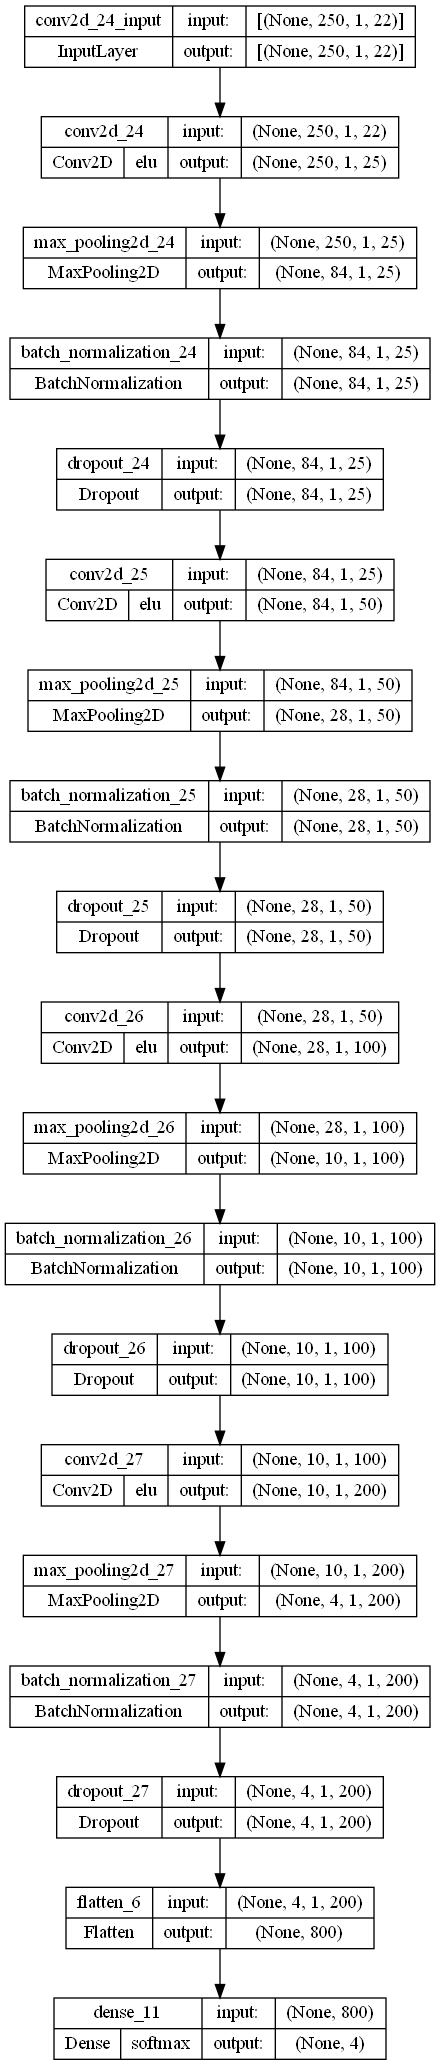

In [13]:
# Building the CNN model using sequential class
cnn_model = Sequential()

# Conv. block 1
cnn_model.add(Conv2D(filters=25, kernel_size=(5,5), padding='same', activation='elu', input_shape=(250,1,22)))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.6))

# Conv. block 2
cnn_model.add(Conv2D(filters=50, kernel_size=(5,5), padding='same', activation='elu'))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.6))

# Conv. block 3
cnn_model.add(Conv2D(filters=100, kernel_size=(5,5), padding='same', activation='elu'))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.6))

# Conv. block 4
cnn_model.add(Conv2D(filters=200, kernel_size=(5,5), padding='same', activation='elu'))
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.6))

cnn_model.add(Flatten()) # Adding a flattening operation to the output of CNN block

# Output layer with Softmax activation 
cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

# Printing the model summary
cnn_model.summary()

plot_model(cnn_model, show_shapes=True, show_layer_activations=True)



In [6]:
# Model parameters
learning_rate = 1e-3
epochs = 100
optimizer = keras.optimizers.Adam(lr=learning_rate)

F:\Programs\anaconda\envs\tensorflow\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [28]:
# Compiling the model
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)




Epoch 1/100
105/105 [==============================] - 3s 14ms/step - loss: 1.3727 - accuracy: 0.3061 - val_loss: 1.3347 - val_accuracy: 0.3679
Epoch 2/100
105/105 [==============================] - 1s 9ms/step - loss: 1.3040 - accuracy: 0.3834 - val_loss: 1.2499 - val_accuracy: 0.4108
Epoch 3/100
105/105 [==============================] - 1s 9ms/step - loss: 1.2318 - accuracy: 0.4493 - val_loss: 1.2319 - val_accuracy: 0.4357
Epoch 4/100
105/105 [==============================] - 1s 9ms/step - loss: 1.1859 - accuracy: 0.4713 - val_loss: 1.1948 - val_accuracy: 0.4492
Epoch 5/100
105/105 [==============================] - 1s 9ms/step - loss: 1.1444 - accuracy: 0.4939 - val_loss: 1.1693 - val_accuracy: 0.4718
Epoch 6/100
105/105 [==============================] - 1s 9ms/step - loss: 1.1239 - accuracy: 0.5046 - val_loss: 1.1642 - val_accuracy: 0.4673
Epoch 7/100
105/105 [==============================] - 1s 9ms/step - loss: 1.1124 - accuracy: 0.5138 - val_loss: 1.1643 - val_accuracy: 0.478

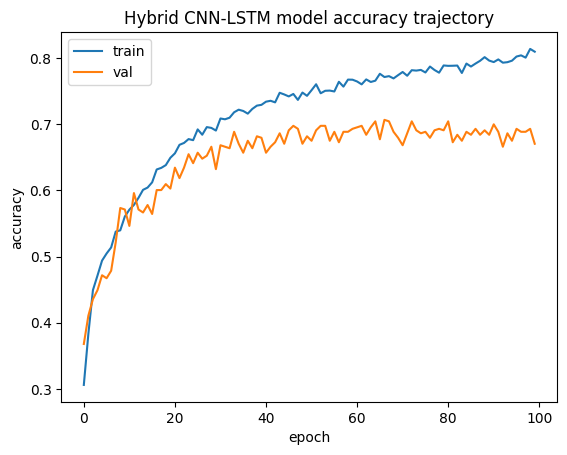

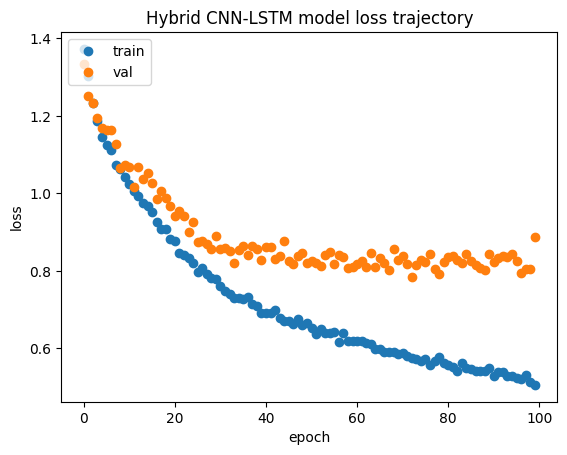

In [29]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('Hybrid CNN-LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [30]:
## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.6636568903923035


In [7]:
# Compiling the model
cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Training and validating the model
cnn_model_results = cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/100
105/105 [==============================] - 6s 9ms/step - loss: 2.2223 - accuracy: 0.2961 - val_loss: 1.3188 - val_accuracy: 0.3634
Epoch 2/100
105/105 [==============================] - 1s 5ms/step - loss: 1.7161 - accuracy: 0.3343 - val_loss: 1.3104 - val_accuracy: 0.3386
Epoch 3/100
105/105 [==============================] - 1s 5ms/step - loss: 1.4605 - accuracy: 0.3734 - val_loss: 1.2050 - val_accuracy: 0.4289
Epoch 4/100
105/105 [==============================] - 1s 5ms/step - loss: 1.3102 - accuracy: 0.4382 - val_loss: 1.1544 - val_accuracy: 0.4582
Epoch 5/100
105/105 [==============================] - 1s 5ms/step - loss: 1.2298 - accuracy: 0.4680 - val_loss: 1.2035 - val_accuracy: 0.4786
Epoch 6/100
105/105 [==============================] - 1s 5ms/step - loss: 1.1750 - accuracy: 0.4931 - val_loss: 1.1466 - val_accuracy: 0.5011
Epoch 7/100
105/105 [==============================] - 1s 5ms/step - loss: 1.1348 - accuracy: 0.5232 - val_loss: 1.0844 - val_accuracy: 0.5734

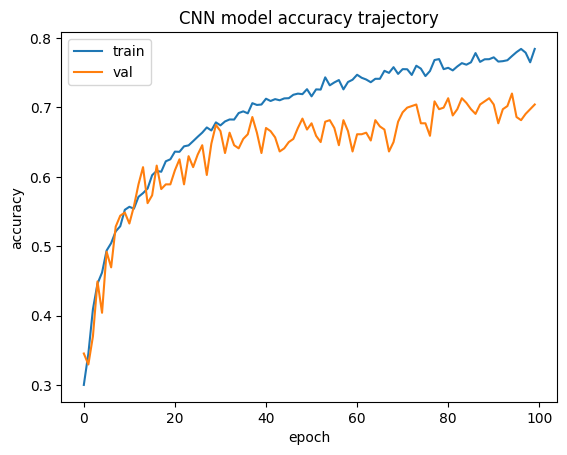

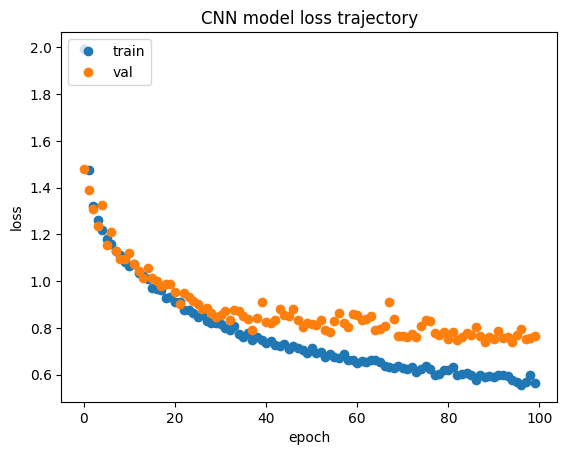

In [32]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(cnn_model_results.history['accuracy'])
plt.plot(cnn_model_results.history['val_accuracy'])
plt.title('CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(cnn_model_results.history['loss'],'o')
plt.plot(cnn_model_results.history['val_loss'],'o')
plt.title('CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [33]:
cnn_score = cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the CNN model:',cnn_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.7020316123962402


In [8]:
# Compiling CNN Single subject the model
keras.backend.clear_session()
cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Training and validating the model
cnn_model_results = cnn_model.fit(x_person_1_train,
             y_person_1_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_person_1_valid, y_person_1_valid), verbose=True)

Epoch 1/100
118/118 [==============================] - 2s 8ms/step - loss: 2.1677 - accuracy: 0.3079 - val_loss: 1.3399 - val_accuracy: 0.3882
Epoch 2/100
118/118 [==============================] - 1s 6ms/step - loss: 1.6526 - accuracy: 0.3412 - val_loss: 1.2931 - val_accuracy: 0.4135
Epoch 3/100
118/118 [==============================] - 1s 6ms/step - loss: 1.4183 - accuracy: 0.3850 - val_loss: 1.3754 - val_accuracy: 0.3966
Epoch 4/100
118/118 [==============================] - 1s 6ms/step - loss: 1.3037 - accuracy: 0.4247 - val_loss: 1.3041 - val_accuracy: 0.3882
Epoch 5/100
118/118 [==============================] - 1s 6ms/step - loss: 1.2208 - accuracy: 0.4637 - val_loss: 1.2095 - val_accuracy: 0.4852
Epoch 6/100
118/118 [==============================] - 1s 6ms/step - loss: 1.1780 - accuracy: 0.4796 - val_loss: 1.2334 - val_accuracy: 0.4726
Epoch 7/100
118/118 [==============================] - 1s 6ms/step - loss: 1.1490 - accuracy: 0.5065 - val_loss: 1.2399 - val_accuracy: 0.4430

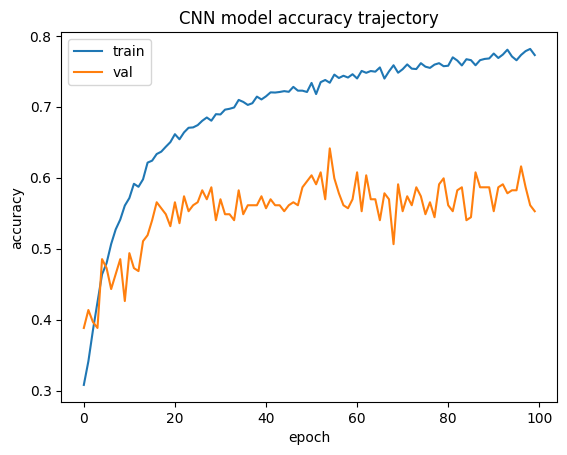

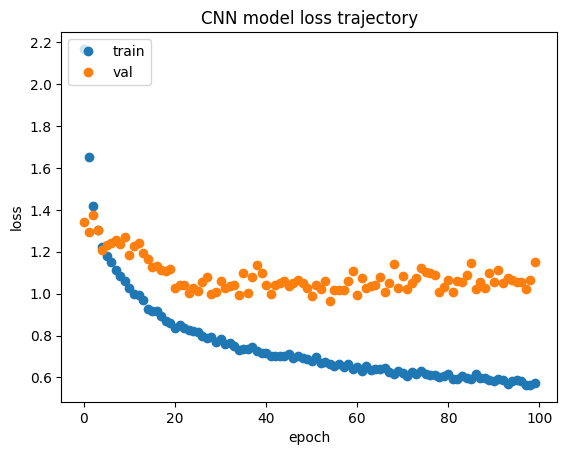

In [10]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(cnn_model_results.history['accuracy'])
plt.plot(cnn_model_results.history['val_accuracy'])
plt.title('CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(cnn_model_results.history['loss'],'o')
plt.plot(cnn_model_results.history['val_loss'],'o')
plt.title('CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
cnn_score = cnn_model.evaluate(x_person_1_test, y_person_1_test, verbose=0)
print('Test accuracy of the CNN 1 subject model:',cnn_score[1])

Test accuracy of the CNN 1 subject model: 0.46000000834465027


In [12]:
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_person_1_train,
             y_person_1_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_person_1_valid, y_person_1_valid), verbose=True)

Epoch 1/100
118/118 [==============================] - 3s 13ms/step - loss: 1.3350 - accuracy: 0.3327 - val_loss: 1.3729 - val_accuracy: 0.3376
Epoch 2/100
118/118 [==============================] - 1s 9ms/step - loss: 1.2267 - accuracy: 0.4364 - val_loss: 1.2245 - val_accuracy: 0.4388
Epoch 3/100
118/118 [==============================] - 1s 9ms/step - loss: 1.1806 - accuracy: 0.4566 - val_loss: 1.2370 - val_accuracy: 0.4388
Epoch 4/100
118/118 [==============================] - 1s 9ms/step - loss: 1.1556 - accuracy: 0.4779 - val_loss: 1.2484 - val_accuracy: 0.4346
Epoch 5/100
118/118 [==============================] - 1s 9ms/step - loss: 1.1388 - accuracy: 0.4892 - val_loss: 1.1893 - val_accuracy: 0.4641
Epoch 6/100
118/118 [==============================] - 1s 9ms/step - loss: 1.1054 - accuracy: 0.5069 - val_loss: 1.2002 - val_accuracy: 0.5232
Epoch 7/100
118/118 [==============================] - 1s 9ms/step - loss: 1.0926 - accuracy: 0.5160 - val_loss: 1.1910 - val_accuracy: 0.481

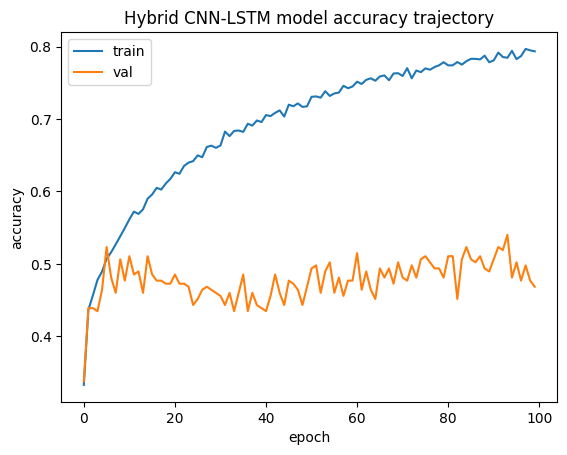

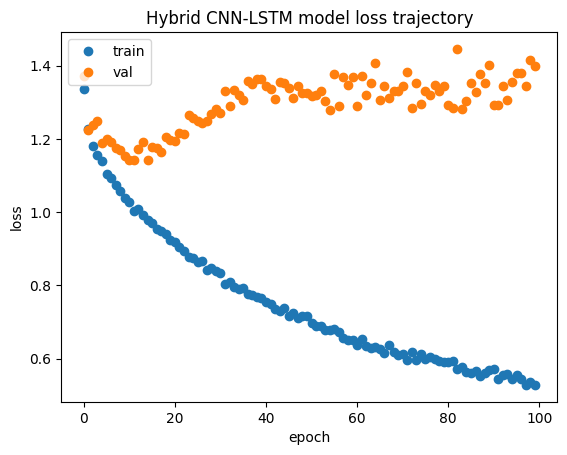

In [13]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('Hybrid CNN-LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [14]:
## Testing the 1 subject hybrid CNN-LSTM model

hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_person_1_test, y_person_1_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM 1 subject model:',hybrid_cnn_lstm_score[1])

Test accuracy of the hybrid CNN-LSTM 1 subject model: 0.5
